# Notebook to compute power spectrum from the halo distribution

## Loading packages

In [61]:
import numpy as np
import MAS_library as MASL
import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 16).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
%matplotlib widget
from scipy.interpolate import interp1d, UnivariateSpline


In [2]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(3, list)
class_data = nested_dict(3, list)
HMF = nested_dict(2, list)


## Loading the halos data

In [3]:
directory_halo = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Halos_snapshots_Box/"

files=["gevolution_boxsize_4032_ngrid_4608_lcdm_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_1_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020",
       "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em4_05062020",
        "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020"];

# redshifts = ["3", "2", "1", "0.5", "0"];
redshifts = ["0"];

files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];



redshift_range=1
for j in range(5): # file
    for i in range(redshift_range): # redshift
#         data['halo'][files_list[j]]['z='+str(redshifts[i])]=np.loadtxt(directory_halo+files[j]+"/output/halos_snapshot/out_"+str(i)+".list");
        data['halo'][files_list[j]]['z='+str(redshifts[i])]=np.loadtxt(directory_halo+files[j]+"/output/halos_snapshot/out_"+str(4)+".list");



# CLASS

In [166]:
#############    
### CLASS ###
#############
directory_class = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/CLASS_powers/"
files_list_class = ['lcdm','cs2_1','cs2_e4','cs2_e7'];
redshifts_class = [100, 50, 30, 10, 4, 3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0];
# CLASS data loading:
for j in range(4):
    
    class_data['bg'][files_list_class[j]]=np.loadtxt(directory_class+files_list_class[j]+"/background.dat");
    for i in range(np.shape(redshifts_class)[0]): # redshift
        class_data['power_cb_lin'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb.dat");
        class_data['power_cb_nl'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb_nl.dat");
        class_data['tk'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_tk.dat")

# CLASS conversion :
k_pivot = 0.05
A_s = 2.1e-9
n_s = 0.96
h = 0.67
k_class = class_data['tk'][files_list_class[0]]["z=0"][:,0]
conversion = A_s*(k_class*h/k_pivot)**(n_s-1)*(2.*np.pi**2/(k_class**3));


# Header

In [7]:
f = open(directory_halo+files[0]+"/output/halos_snapshot/out_"+str(0)+".list")
header = f.readline()
header_list = header.split(' ') #list of columns
print(header_list)
# print(header_list.index("Mvir"))

['#ID', 'DescID', 'Mvir', 'Vmax', 'Vrms', 'Rvir', 'Rs', 'Np', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'Spin', 'rs_klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'spin_bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Halfmass_Radius\n']


# Halos 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


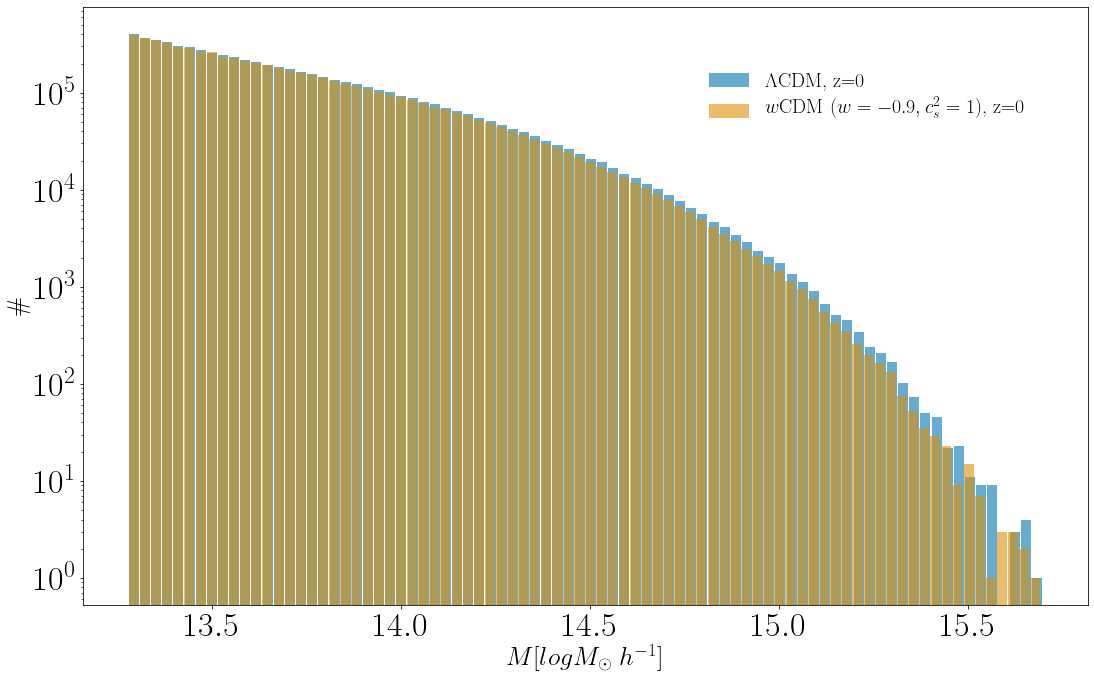

In [8]:
%matplotlib inline
import matplotlib as mpl
label_size = 34
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 11)
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)

redshifts = ["0"];
files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ", "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ",
          "$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM-kev ($w=-0.9, c_s^2=10^{-7}$), "]
l=0
# for i in [0,1,2,3,4]: # file
for i in [0,1]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);

        x=data['halo'][files_list[i]][redshift][:,2];
        plt.hist(np.log10(x), density=False,bins=82, rwidth=0.9,alpha=0.6,color=Colors[l], label=decrip[i]+redshift,histtype='bar')  # density=False would make counts
#         plt.title('Halo mass function')
        plt.ylabel('\#')
        plt.xlabel(r'$M[log M_{\odot} \; h^{-1}$]')
        plt.yscale('log')
        plt.legend(fontsize=20,bbox_to_anchor=[0.78,0.85],loc="center",frameon=False)

        l=l+1
        

plt.show()


# Interpolation and taking the derivative

In [229]:
HMF = nested_dict(4, list)

In [324]:

nbins = 60;
for i in [0,1,2,3,4]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        x=data['halo'][files_list[i]][redshift][:,2];
        HMF['sim']['count'][files_list[i]][redshift] = np.histogram(np.log10(x), bins=nbins)[0]
        HMF['sim']['bin_edges'][files_list[i]][redshift] = np.histogram(np.log10(x), bins=nbins)[1]
        HMF['sim']['fit'][files_list[i]][redshift] = UnivariateSpline(HMF['sim']['bin_edges'][files_list[i]][redshift][:-1], HMF['sim']['count'][files_list[i]][redshift], k=2)
        HMF['sim']['der_interp'][files_list[i]][redshift] = HMF['sim']['fit'][files_list[i]][redshift].derivative(n=1);


## Compare

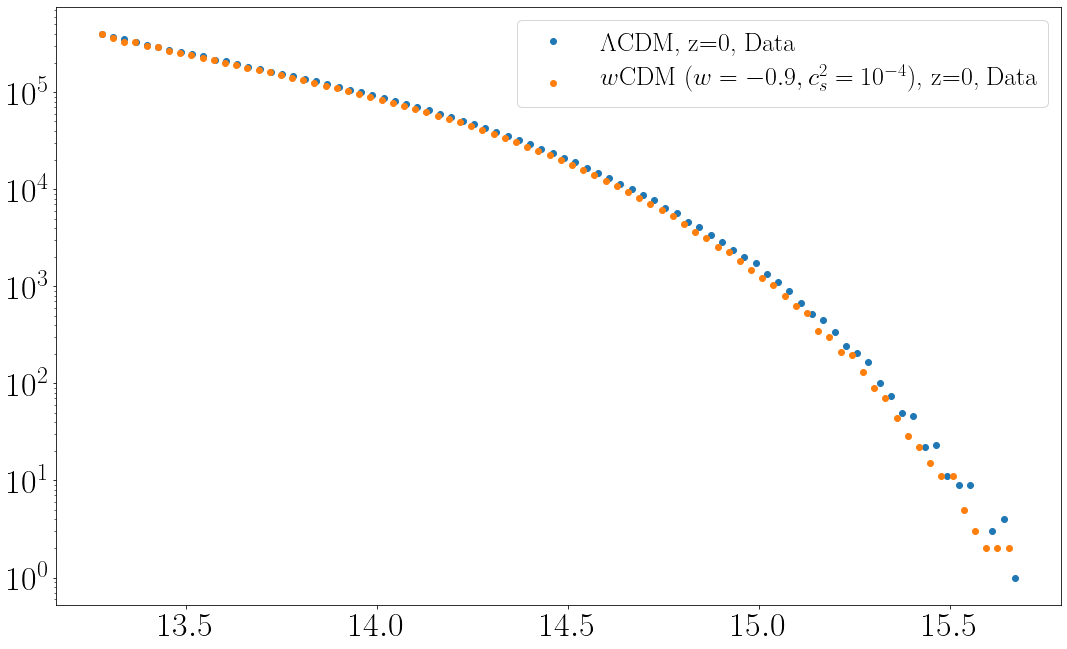

In [288]:
%matplotlib inline
import matplotlib as mpl
label_size = 34
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 11)
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ", "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ",
          "$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM-kev ($w=-0.9, c_s^2=10^{-7}$), "]

for i in [0,2]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
        counts = HMF['sim']['count'][files_list[i]][redshift]
        fitting = HMF['sim']['fit'][files_list[i]][redshift]
        hmf_sim = HMF['sim']['der_interp'][files_list[i]][redshift]
        
        plt.semilogy(bin_edges[:-1],counts,"o", label =decrip[i]+redshift+ ", Data" )
#         plt.semilogy(bin_edges[:],fitting(bin_edges[:]),"o", label =decrip[i]+redshift +  ", fitting" )
#         plt.semilogy(bin_edges[:],hmf_sim(bin_edges[:]),"o", label = decrip[i]+redshift + ", derivative" )

plt.legend()

# Tinker Halo mass function

In [318]:
import numpy as np
import mass_function_library as MFL

# halo mass function parameters
# j=0;i=0;
files_list_class = ['lcdm','cs2_1','cs2_e4','cs2_e7'];


M_min = 13.2
M_max = 16
num = 60

for i in [0,1,2,3]: # file
# for i in [0]: # file

# for i in [0]: # file
    for j in [0]: # Redshifts
        Pk =  class_data['power_cb_lin'][files_list_class[i]]['z=0'][:,1]  #file with linear Pk
        k =  class_data['power_cb_lin'][files_list_class[i]]['z=0'][:,0]  #file with linear Pk
        # Pk=k**3/(2.*np.pi**2)*Pk
        OmegaM = 0.319
        Masses = np.logspace(M_min, M_max, num) #array with halo masses
        author = 'Tinker'   #Sheth-Tormen halo mass function
        bins   = 200  #number of bins to use for Pk
        z      = 0.0    #redshift; only used for Tinker, Tinker10 and Crocce
        delta  = 200.0  #overdensity; only for Tinker and Tinker10

        # read linear matter Pk

        # compute halo mass function

        HMF_data = MFL.MF_theory(k, Pk, OmegaM, Masses, author, bins, z, delta)
        HMF['lin']['dNdlogM'][files_list_class[i]]['z='+str(redshifts_class[j])] = HMF_data;
        deltaM = (10**M_max-10**M_min)/(num-1)
#         HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]  = (HMF_data[:]+roll(HMF_data[:],-1))*(roll(Masses,-1)-Masses[:])/2.
        HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]  = (HMF_data[:])*(roll(Masses,-1)-Masses[:])

        
        

Delta= 200.0
A= 0.186
a= 1.47
b= 2.57
c= 1.19
Delta= 200.0
A= 0.186
a= 1.47
b= 2.57
c= 1.19
Delta= 200.0
A= 0.186
a= 1.47
b= 2.57
c= 1.19
Delta= 200.0
A= 0.186
a= 1.47
b= 2.57
c= 1.19


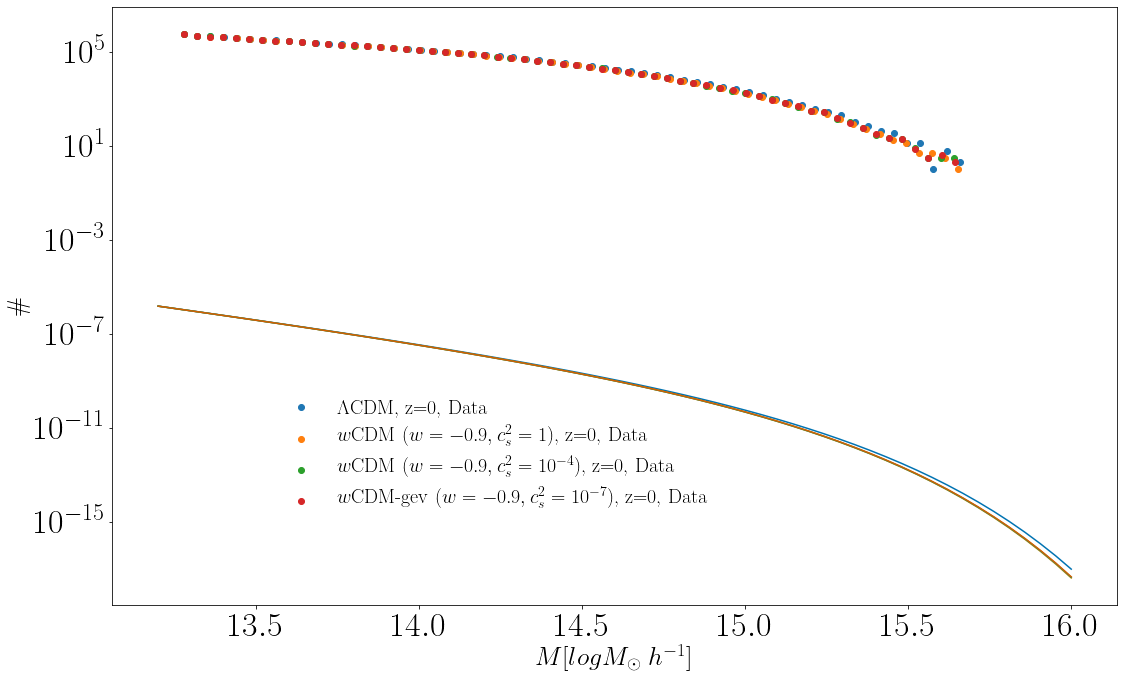

In [321]:
%matplotlib inline
import matplotlib as mpl
label_size = 34
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 11)
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)

redshifts = ["0"];
files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ", "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ",
          "$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM-kev ($w=-0.9, c_s^2=10^{-7}$), "]
l=0
boxsize=4032;
for i in [0,1,2,3]: # file
# for i in [0]: # file

# for i in [0]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        # compute halo mass function
        f = HMF_data
        
        plt.plot(log10(Masses),HMF['lin']['dNdlogM'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 *  ,color=Colors[l])  # density=False would make counts

#         plt.plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 ,color=Colors[l+1], label=decrip[i]+redshift)  # density=False would make counts

#         plt.plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 ,color=Colors[l], label=decrip[i]+redshift)  # density=False would make counts
        
        redshift ="z="+str(j);
        bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
        counts = HMF['sim']['count'][files_list[i]][redshift]
#         plt.plot(bin_edges[:-1],counts,"o",color=Colors[l], label =decrip[i]+redshift)
#         plt.errorbar(bin_edges[:-1],counts, yerr=np.sqrt(counts), fmt="o",label =decrip[i]+redshift)
        bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
        counts = HMF['sim']['count'][files_list[i]][redshift]
        fitting = HMF['sim']['fit'][files_list[i]][redshift]
        hmf_sim = HMF['sim']['der_interp'][files_list[i]][redshift]
        
        plt.semilogy(bin_edges[:-1],counts,"o", label =decrip[i]+redshift+ ", Data" )
        #         plt.title('Halo mass function')
        plt.ylabel('\#')
        plt.xlabel(r'$M[log M_{\odot} \; h^{-1}$]')
        plt.yscale('log')
        plt.legend(fontsize=20,bbox_to_anchor=[0.38,0.25],loc="center",frameon=False)

        l=l+1
        

plt.show()


Text(0.5, 0, '$M[log M_{\\odot} \\; h^{-1}$]')

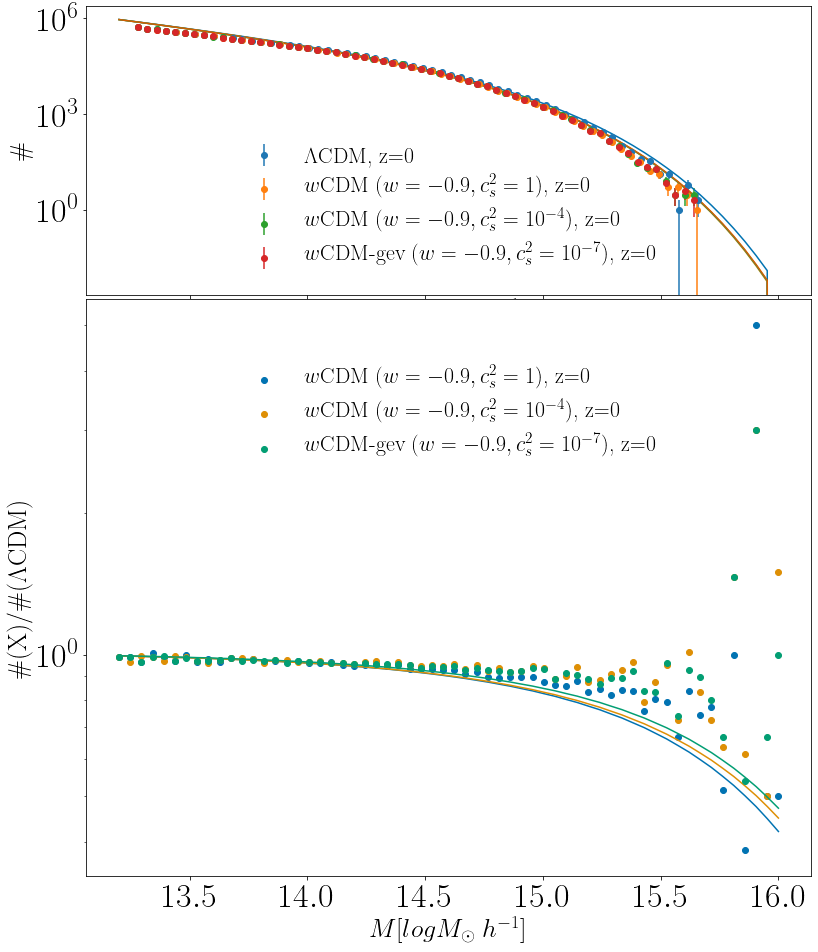

In [325]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        # compute halo mass function        
        axs[0].plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3*h**3 ,color=Colors[l])  # density=False would make counts

#         plt.plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 ,color=Colors[l+1], label=decrip[i]+redshift)  # density=False would make counts

#         plt.plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 ,color=Colors[l], label=decrip[i]+redshift)  # density=False would make counts
        
        redshift ="z="+str(j);
        bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
        counts = HMF['sim']['count'][files_list[i]][redshift]
#         plt.plot(bin_edges[:-1],counts,"o",color=Colors[l], label =decrip[i]+redshift)
        axs[0].errorbar(bin_edges[:-1],counts, yerr=np.sqrt(counts), fmt="o",label =decrip[i]+redshift)

        #         plt.title('Halo mass function')
        axs[0].set_ylabel('\#')
        axs[0].set_xlabel(r'$M[log M_{\odot} \; h^{-1}$]')
        axs[0].set_yscale('log')
        axs[0].legend(fontsize=20,bbox_to_anchor=[0.38,0.25],loc="center",frameon=False)

        l=l+1

axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.3], loc='center',frameon=False)
# Relative difference:

# RSD ='RSD'
# l=0
# for num1 in [0,1,2,3,4]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             if(num1!=num2):
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][z[j]][[0,1],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][z[j]][[0,1],:]
#                 axs[1].plot(k1,(pk1)/pk2,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
#                 l=l+1;

# l=0
# for num1 in [1,2,3]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             if(num1!=num2):
l=0
#                 ### CLASS transfer
for num1 in [1,2,3]: # file 1
    for num2 in [0]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
        # compute halo mass function
            data_1 = HMF['lin']['N'][files_list_class[num1]]['z='+str(redshifts_class[j])];
            data_ref = HMF['lin']['N'][files_list_class[num2]]['z='+str(redshifts_class[j])];
        
            axs[1].plot(log10(Masses),data_1/data_ref ,color=Colors[l])  # density=False would make counts
            
            bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
            counts1 = HMF['sim']['count'][files_list[num1]][redshift]
            counts_ref = HMF['sim']['count'][files_list[num2]][redshift]
            axs[1].plot(log10(Masses),counts1/counts_ref,"o" ,color=Colors[l],label =decrip[num1]+redshift) # density=False would make counts

        
        #         plt.title('Halo mass function')


        l=l+1


axs[1].set_yscale('log')
axs[1].legend(fontsize=20,bbox_to_anchor=[0.38,0.25],loc="center",frameon=False)
axs[1].set_ylabel(r'\#(X)/\#($\Lambda$CDM)')

# axs[1].set_xscale('log')
# axs[1].set_ylim(0.97,1.07)
# axs[1].set_xlim(1.e-3,1.5)
# # axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center',frameon=False)
axs[1].set_xlabel(r'$M[log M_{\odot} \; h^{-1}$]')

# plt.savefig('RSD_halos_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )


Text(0.5, 0, '$M[log M_{\\odot} \\; h^{-1}$]')

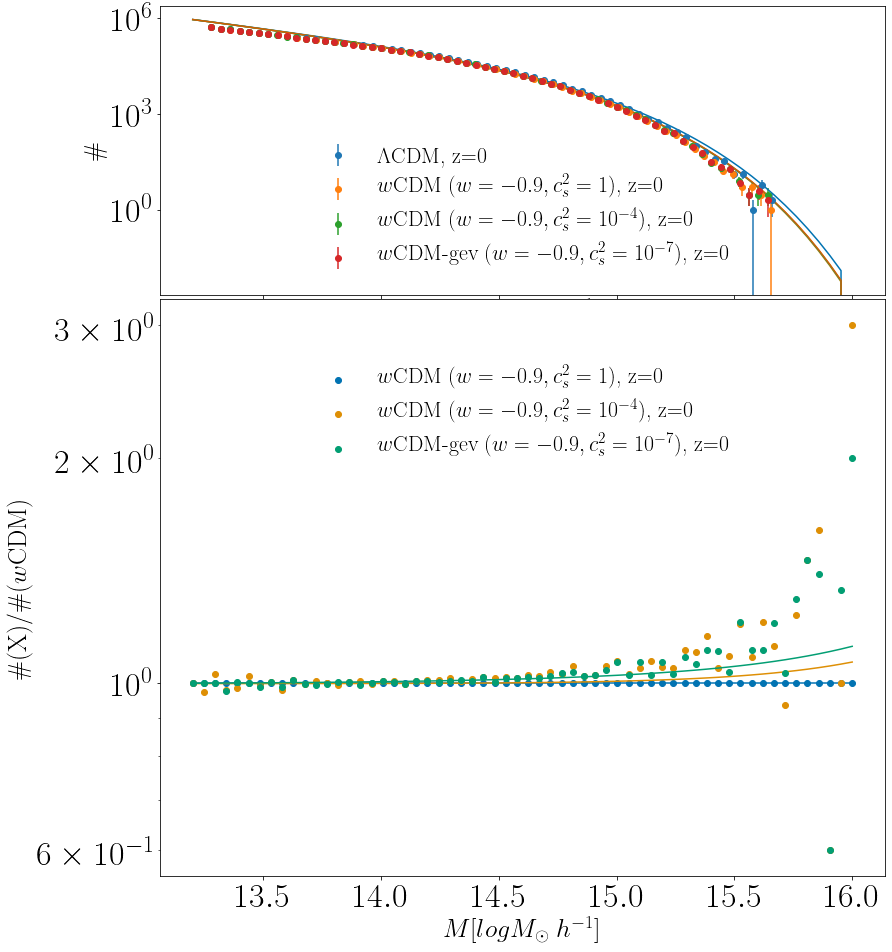

In [315]:
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(figsize=(13,16),nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[1,2]})
plt.subplots_adjust(hspace=0.01)



kind = 'halo'
RSD ='RSD'
file = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ",
          "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ","$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ","$w$CDM ($w=-0.9, c_s^2=10^{-7}$), "]
z = ["z=0", "z=0.5", "z=1", "z=2", "z=3"];

l=0
for i in [0,1,2,3]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);
        # compute halo mass function        
        axs[0].plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3*h**3 ,color=Colors[l])  # density=False would make counts

#         plt.plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 ,color=Colors[l+1], label=decrip[i]+redshift)  # density=False would make counts

#         plt.plot(log10(Masses),HMF['lin']['N'][files_list_class[i]]['z='+str(redshifts_class[j])]*boxsize**3 ,color=Colors[l], label=decrip[i]+redshift)  # density=False would make counts
        
        redshift ="z="+str(j);
        bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
        counts = HMF['sim']['count'][files_list[i]][redshift]
#         plt.plot(bin_edges[:-1],counts,"o",color=Colors[l], label =decrip[i]+redshift)
        axs[0].errorbar(bin_edges[:-1],counts, yerr=np.sqrt(counts), fmt="o",label =decrip[i]+redshift)

        #         plt.title('Halo mass function')
        axs[0].set_ylabel('\#')
        axs[0].set_xlabel(r'$M[log M_{\odot} \; h^{-1}$]')
        axs[0].set_yscale('log')
        axs[0].legend(fontsize=20,bbox_to_anchor=[0.38,0.25],loc="center",frameon=False)

        l=l+1

axs[0].legend(fontsize=22,bbox_to_anchor=[0.5, 0.3], loc='center',frameon=False)
# Relative difference:

# RSD ='RSD'
# l=0
# for num1 in [0,1,2,3,4]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             if(num1!=num2):
#                 [k1,pk1]=data[kind][RSD][file[num1]]['pow'][z[j]][[0,1],:]
#                 [k2,pk2]=data[kind][RSD][file[num2]]['pow'][z[j]][[0,1],:]
#                 axs[1].plot(k1,(pk1)/pk2,"o",color =Colors[l], lw=3,label=decrip[num1]+" "+z[j])
#                 l=l+1;

# l=0
# for num1 in [1,2,3]: # file 1
#     for num2 in [0]: # file2
#         for j in [0]: # Redshifts
#             if(num1!=num2):
l=0
#                 ### CLASS transfer
for num1 in [1,2,3]: # file 1
    for num2 in [1]: # file2
        for j in [0]: # Redshifts
            redshift ="z="+str(j);
        # compute halo mass function
            data_1 = HMF['lin']['N'][files_list_class[num1]]['z='+str(redshifts_class[j])];
            data_ref = HMF['lin']['N'][files_list_class[num2]]['z='+str(redshifts_class[j])];
        
            axs[1].plot(log10(Masses),data_1/data_ref ,color=Colors[l])  # density=False would make counts
            
            bin_edges = HMF['sim']['bin_edges'][files_list[i]][redshift]
            counts1 = HMF['sim']['count'][files_list[num1]][redshift]
            counts_ref = HMF['sim']['count'][files_list[num2]][redshift]
            axs[1].plot(log10(Masses),counts1/counts_ref,"o" ,color=Colors[l],label =decrip[num1]+redshift) # density=False would make counts

        
        #         plt.title('Halo mass function')


        l=l+1


axs[1].set_ylabel(r'\#(X)/\#($w$CDM)')
axs[1].set_yscale('log')
axs[1].legend(fontsize=20,bbox_to_anchor=[0.38,0.25],loc="center",frameon=False)

# axs[1].set_xscale('log')
# axs[1].set_ylim(0.97,1.07)
# axs[1].set_xlim(1.e-3,1.5)
# # axs[1].set_yticks([-0.1,-0.05,0,0.05,0.1,0.2,0.3])  
axs[1].legend(fontsize=22,bbox_to_anchor=[0.5, 0.8], loc='center',frameon=False)
axs[1].set_xlabel(r'$M[log M_{\odot} \; h^{-1}$]')

# plt.savefig('RSD_halos_monopole.pdf', format='pdf',dpi=300, bbox_inches='tight' )
